### Comparador de Tensão CMOS Calibrado por SGA

O objetivo é calibrar um comparador de tensão envolvendo dois transistores e um inversor. 

A seguir o circuito a ser calibrado:

![title](./comp_img.png)

Os transistores M3 e M4 tem as respectivas dimensões fixas:

* W3 = 3u
* L3 = 1u
* W4 = 1u
* L4 = 1u

A fonte de tensão $V_{in}$ tem amplitude de 1.65 V e valor DC de 1.65 V (varia de 0 até 3.3 V).

Definindo-se uma tensão de limiar, o comparador será ajustado variando a fonte de tensão $V_{bias}$ e as dimensões dos transistores M1 e M2.




## Definições de iniciais

In [1]:
import matplotlib.pyplot as plt
import PySpice
import PySpice.Logging.Logging as Logging
import numpy as np

logger = Logging.setup_logging()

from PySpice.Doc.ExampleTools import find_libraries
from PySpice.Probe.Plot import plot
from PySpice.Spice.Library import SpiceLibrary
from PySpice.Spice.Netlist import Circuit
from PySpice.Unit import *

# Passos da simulação
Steps = 100

# Tensão de alimentação
Vdd = 3.3

## Definição da aptidão

O calculo da patidão funciona da seguinte maneira: 

* Cada indivíduo representa uma possível configuração do circuito, ou seja, valores de W1, L1, W2, L2 e Vbias.
* Para um dado indivíduo, o circuito é simulado e a saída é observada.
* É calculado o RMSE entre a saída obtida e a saída ideal ((Vin > limiar) * Vdd)
* Para que a aptidão seja uma função crescente, basta inverter o RMSE de modo que Aptidão = 1/RMSE

In [2]:
# Faz o calculo do RMSE entre a saida ideal e a saida obtida
# "target" indica o limiar de tensao que o comparador deve mudar de nivel logico
def rmse_out(vin, vout, target):
    target_wave = (vin > target)*Vdd
    return np.sqrt(np.mean((vout-target_wave)**2))

In [3]:
#Para um dado individuo x = [w1, l1, w2, l2, vbias], simula o circuito e returna a saida e a entrada
def simulate(x):
    # Inicializa o circuit
    circuit = Circuit('NMOS Transistor')
    # Biblioteca contendo os transistores utilziados
    circuit.include('./Libs/CMOS35.lib')
    
    # Fonte de polarizacao de M2
    Bias = x[4]
    
    # Definindo a Netlist:
    
    # Definindo as fontes de tensao do circuito
    # V <name> <positive node> <negative node> <value>
    VVdd = circuit.V('vdd', 'vddnode', circuit.gnd, u_V(Vdd))
    VBias = circuit.V('vbias', 'vbiasnode', circuit.gnd, u_V(Bias))
    Vin = circuit.SinusoidalVoltageSource('vinp', 'vin', circuit.gnd, amplitude=u_V(Vdd/2), frequency=u_Hz(InFreq), offset=u_V(Vdd/2))

    # Definindo os transistores
    # Por simplificacao, os valores de x[0:3] foram definidos na escala de um (i.e. w = x[i]*1u)
    # M <name> <drain node> <gate node> <source node> <bulk/substrate node>
    circuit.MOSFET(1, 'vout', 'vcomp', circuit.gnd, circuit.gnd, model='MODN', w=1e-6,l=1e-6)
    circuit.MOSFET(2, 'vout', 'vcomp', 'vddnode', 'vddnode', model='MODP', w=3e-6,l=1e-6)
    circuit.MOSFET(3, 'vcomp', 'vbiasnode', circuit.gnd, circuit.gnd, model='MODN', w=x[0]*1e-6,l=x[1]*1e-6)
    circuit.MOSFET(4, 'vcomp', 'vin', 'vddnode', 'vddnode', model='MODP', w=x[2]*1e-6,l=x[3]*1e-6);
    
    # Realiza a simulacao em si
    simulator = circuit.simulator(temperature=25, nominal_temperature=25)
    analysis = simulator.transient(step_time=Vin.period/Steps, end_time=Vin.period*2.1)
    
    # A entrada não inicializa exatamente em 0, por isso, para que que a comparação seja justa
    # não é possivel assumir que a entrada é apenas uma senoide. É necessário saber exatamente
    # em que ponto essa senoide comeca
    # Dessa forma, alem da saida, tambem é retornada a entrada
    return analysis['vin'].as_ndarray(), analysis['vout'].as_ndarray()

In [4]:
# Calculo da aptidão
# Para um dado indivíduo x, simula o circuito, calcula o RMSE e retorna 1/RMSE
def calc_fitness(x, target):
    vin, vout = simulate(x)
    rmse = rmse_out(vin, vout, target)
    return 1/rmse

## Algorítmo Genético Simples (SGA)

O SGA se divide nas seguintes etapas:

* Avaliação:
    * Os individuos são ordenados de forma decrescente por aptidão
* Seleção dos pais:
    * Os k individuos com maior aptidão são selecionados para fazer parte do conjunto de possíveis pais
* Cruzamento
    * 2 pais são selecionados aleatóriamente e um novo indivíduo (filho) é gerado a partir deles
    * Cada parâmetro (Ws, Ls e Vbias) do filho é a média dos respectivos parâmetros dos pais
    * Os filhos gerados pelo cruzamento substituem a população da geração anterior
* Mutação
    * Após o cruzamento, para cada indíduo, há chance de um ou mais parâmetros serem modificados
    * Caso seja modificado, o parâmetro é acrescido de um falor aleatório entre -max_inc e max_inc


In [229]:
#Simple Genetic Algorithm

#Xs: individuos
#gens: gerações
#k: numero de melhores individuos que poderão ser pais
#mu: numero de individuos por geração
#max_inc: valores máximos de incremento na mutação
#target: tensão de limiar alvo do comparador
#n_params: numero de parametros que cada indivíduo representa
#limits: valores limite para os parâmetros
#mut_rate: taxa de mutação

def SGA (Xs, gens, k, mu, max_inc, target, n_params, limits, mut_rate):
    
    # Declaração dos vetores que seão utilizados em todas as gerações para evitar
    # re-alocar memória a cada iteração do loop (faz mais diferença quando o tempo de execução
    # não é dominado pela função custo)
    
    # k melhores individuos, possíveis pais
    parents = np.zeros((k, n_params+1))
    
    # Dupla de pais utilzada na mutação
    p1 = np.zeros((n_params+1,))
    p2 = np.zeros((n_params+1,))
    
    # Melhor Indivíduo
    bestX = np.zeros((n_params+1,))
    bestS = 0
    
    # histórico da melhor aptidão em cada geração
    Jhist = np.zeros((gens,))
    
    # aptidões de cada indivído em uma dada geração
    scores = np.zeros((mu,))
    
    for gen in range(0, gens):
        
        # Avaliação
        # Para cada indivíduo, calcular a aptidão
        for i in range(0, mu):
            scores[i] = calc_fitness(Xs[i, :], target)
            if scores[i] > bestS:
                bestS = scores[i]
                bestX = Xs[i, :]
        
        # A maior aptidão é guardada
        maxIdx = np.argmax(scores)

        Jhist[gen] = scores[maxIdx]
        
        # Selecao dos Pais
        # k melhores indivíduos se tornam possíveis pais
        topIdx = np.argsort(scores)[::-1]
        for i in range(0, k):
            for j in range(0, n_params+1):
                parents[i, j] = Xs[topIdx[i], j]
        
        # Crossover
        # Dois dentre os possíveis pais são selecionados aleatoriamente
        for i in range(0, mu):
            r1 = np.random.randint(0, k)
            r2 = np.random.randint(0, k)
            
            # Cada parâmetro do indivíduo resultante é a média dos parâmetros dos pais
            for j in range(0, n_params+1):
                Xs[i, j] = parents[r1, j]/2 + parents[r2, j]/2
        
        # Mutação
        for i in range(0, mu):
            # Mutação apenas dos Ws e Ls
            # Para os Ws e Ls o incremento e limites é diferente
            for j in range(0, n_params):
                if np.random.rand() <= mut_rate:
                    increment = np.random.uniform(-max_inc[0], max_inc[0])
                    Xs[i, j] += increment
                    
                    # Caso o parâmetro fique fora dos limites, força a voltar "rebatendo" o incremento
                    if Xs[i, j] < limits[0, 0] or Xs[i, j] > limits[0, 1]:
                        Xs[i, j] -= 2*increment
                        
            # Mutação apenas do Vbias
            if np.random.rand() <= mut_rate:
                increment = np.random.uniform(-max_inc[1], max_inc[1])
                Xs[i, n_params] += increment
                if Xs[i, n_params] < limits[1, 0] or Xs[i, n_params] > limits[1, 1]:
                    Xs[i, n_params] -= 2*increment
                    
        
    # Na ultima interação, recalcular as aptidões por conta da mutação que ocorreu
    # no final do último loop
    for i in range(0, mu):
        scores[i] = calc_fitness(Xs[i, :], target)
        if scores[i] > bestS:
            bestS = scores[i]
            bestX = Xs[i, :]
    
    # Retorna respectivamente, 
    # a maior aptidão ao final das iterações, 
    # o melhor indivído ao final das iterações, 
    # o histórico de melhores aptidões de cada geração
    return bestS, bestX, Jhist

## Execução do SGA em si

In [230]:
# Definição dos parâmetros

# Número de vezes que o algorítmo será executado
runs = 10

mu = 10
gens = 50
k = 2
mut_rate = 0.8
target = 1
n_params = 4

# Limites do incremento a cada mutação para Ws/Ls e Vbias
max_inc = [0.3, 0.1]

# Valores limites de Ws/Ls e Vbias
limits = np.array([[1, 10], [0.5, Vdd]])

# Valores de retorno da função SGA ao longo de "run" execuções
allX = np.zeros((runs, n_params+1))
allS = np.zeros((runs, 1))
allJ = np.zeros((runs, gens))

# Contadores simples do progresso da execução
progress = 0
progress_t = 0

for j in range(0, runs):
    
    # Fixar a semente em cada rodada para que os resultados sejam reprodutíveis
    np.random.seed(j)

    # População inicial aleatória denetro dos valores limite
    Xs = np.random.uniform(limits[0, 0],limits[0, 1], (mu, n_params+1))
    Xs[:, n_params] = np.random.uniform(limits[1, 0],limits[1, 1], (1, mu))
     
    # Execução de uma rodada do SGA
    minS, minX, Jhist = SGA(Xs, gens, k, mu, max_inc, target, n_params, limits, mut_rate)
    allX[j, :] = minX
    allS[j] = minS
    allJ[j, :] = Jhist.ravel()
    progress += 1
    progress_t += 1
    
    if(progress >= runs/20):
        progress = 0
        print("Progresso: ", progress_t/runs * 100,"%")


Progresso:  10.0 %
Progresso:  20.0 %
Progresso:  30.0 %
Progresso:  40.0 %
Progresso:  50.0 %
Progresso:  60.0 %
Progresso:  70.0 %
Progresso:  80.0 %
Progresso:  90.0 %
Progresso:  100.0 %


## Histórico de Aptidões

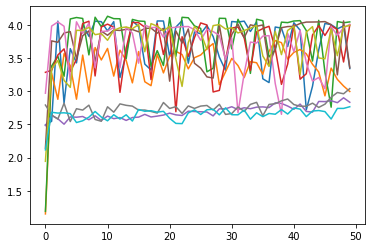

In [231]:
for i in range(0, runs):
    plt.plot(allJ[i, :])
plt.title("Historico da maior aptidão")
plt.xlabel("Geração")
plt.ylabel("Aptidão")
plt.show()

## Vizualização do Melhor Resultado

Observa todas as rodadas e simula o circuito para o melhor indivíduo dentro dessas rodadas

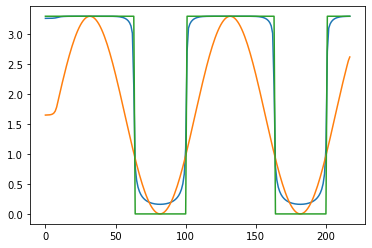

1.0356250260081532
4.052336090153835
[4.8751628  4.41330991 8.59207637 8.2671983  1.18549892]


In [232]:
# Melhor x dentre todas as rodadas
bestX = allX[np.argmax(allS), :]

# Simulação com os melhores parâmetros
vin, vout = simulate(bestX)
target_wave = (vin > target)*Vdd

# Plot
plt.plot(vin)
plt.plot(vout)
plt.plot(target_wave)
plt.legend(['Vin', 'Vout', 'Saida Ideal'])
plt.ylabel("Tensão (V)")
plt.xlabel("Passos de simulação")
plt.grid()
plt.show()
print("Melhor Aptidão: ", calc_fitness(bestX, target))
print("Melhor Indivíduo: ", bestX)